# Задание, оцениваемое сокурсниками: Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.        
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Qp,q,P,Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.
- Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
#импортируем все нужные модули:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

#и еще напишем новую функцию, например, функцию, которая делает обратное преобразование Бокса-Кокса.
# (т.к. ее реализации нет в питоне)
def invboxcox(y,lmbda):
    if lmbda==0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [50]:
#загружаем наши данные
data = pd.read_csv("WAG_C_M.csv", ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [161]:
data.head()

,WAG_C_M,box,sales_box_diff,sales_box_double_diff
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN


In [51]:
data['WAG_C_M'][:5]

month
1993-01-01    15.3
1993-02-01    19.1
1993-03-01    23.6
1993-04-01    30.6
1993-05-01    37.5
Name: WAG_C_M, dtype: float64

## 1.Визуальный анализ ряда

Text(0, 0.5, 'Средняя зарплата')

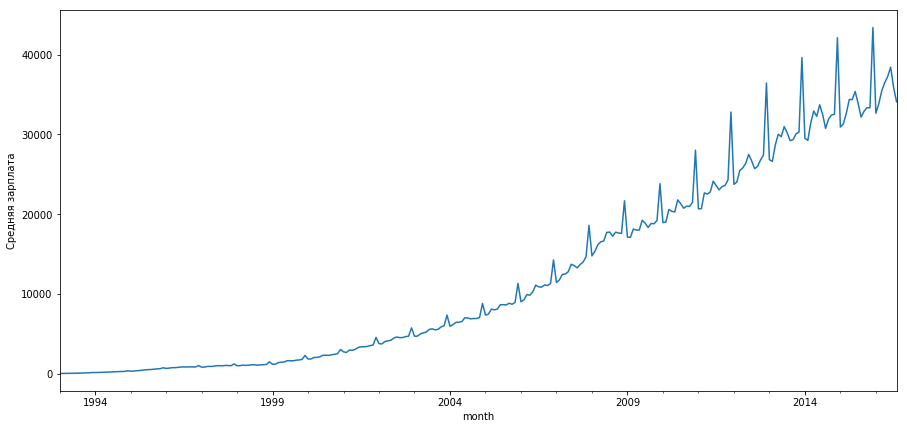

In [171]:
plt.figure(figsize(15,7))
#plt.plot(data)
data['WAG_C_M'].plot()
plt.ylabel(u'Средняя зарплата')

Видим, что график вообще не стационарный, на нем есть:
    - ярко выраженный повышающийся тренд
    - сезонность
    - нестационарная дисперсия(размах сезонных колебаний в начале ряда гораздо меньше, чем в конце)
    
Сначала стабилизируем дисперсию, потом будем дифференцировать.

## 2.Стабилизация дисперсии

Итак, сначала стабилизируем дисерсию. Это за нас сделают Бокс и Кокс(с помощью функции **boxcox**):

In [57]:
data['box'], lmbda = stats.boxcox(data)  #добавим к нашей табличке еще один столбец с преобразованием Бокса-Кокса

Критерий Дики-Фуллера p=0.696899


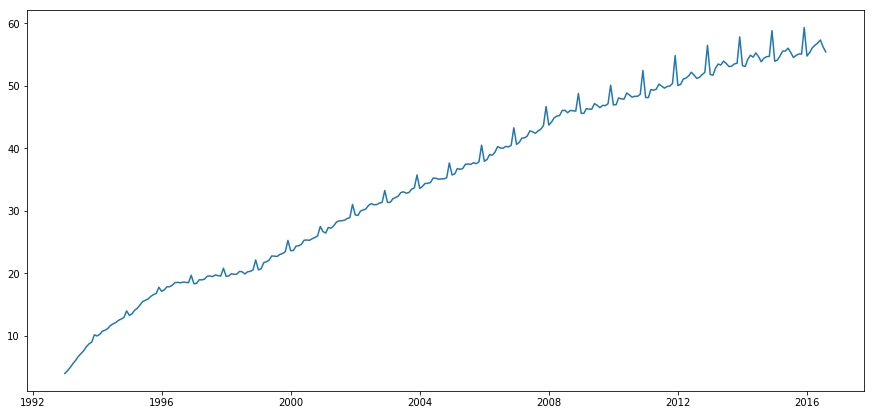

In [70]:
plt.figure(figsize(15, 7))
plt.plot(data['box'])
print('Критерий Дики-Фуллера p=%f' %sm.tsa.stattools.adfuller(data['box'])[1])

Ну, вроде бы с дисперсией стало получше(ее значения стали чуть больше в начале и поменьше в конце ряда)  
Но ряд все равно не поход на стационарный из-за тренда.(кроме того, критерий Дики-Фуллера подтверждает нестационарность)  
Так что пришло время избавиться от тренда(с помощью дифференцирования):    

## 3. Выбор порядка дифференцирования

Начнем с сезонного дифференцирования.               
По определению, сезонное дифференцирование - переход к попарным разностям соседних значений.       
Так что просто из исходного ряда вычитаем значения этого же ряда, смещенного на 12 месяцев:

In [74]:
data['sales_box_diff']= data['box']-data['box'].shift(12)

In [76]:
#вроде чет получилось
data['sales_box_diff'][:5]

month
1993-01-01   NaN
1993-02-01   NaN
1993-03-01   NaN
1993-04-01   NaN
1993-05-01   NaN
Name: sales_box_diff, dtype: float64

Критерий Дики-Фуллера p=0.014697


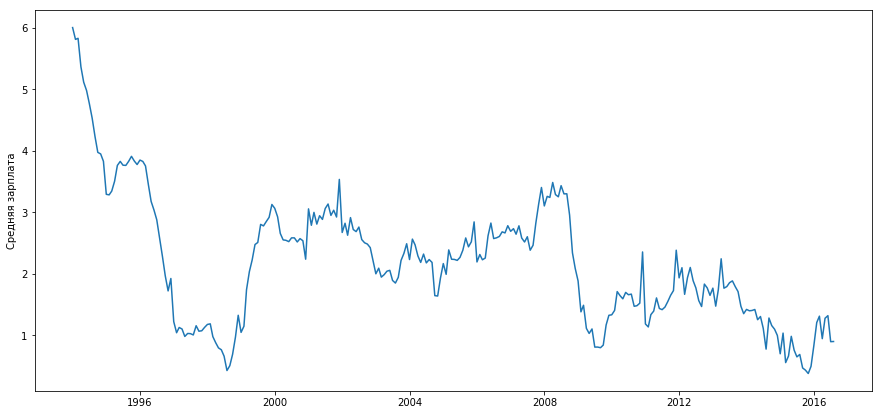

In [93]:
plt.figure(figsize(15,7))
plt.ylabel('Средняя зарплата')
plt.plot(data['sales_box_diff'])
print('Критерий Дики-Фуллера p=%f' %sm.tsa.stattools.adfuller(data['sales_box_diff'][12:])[1])

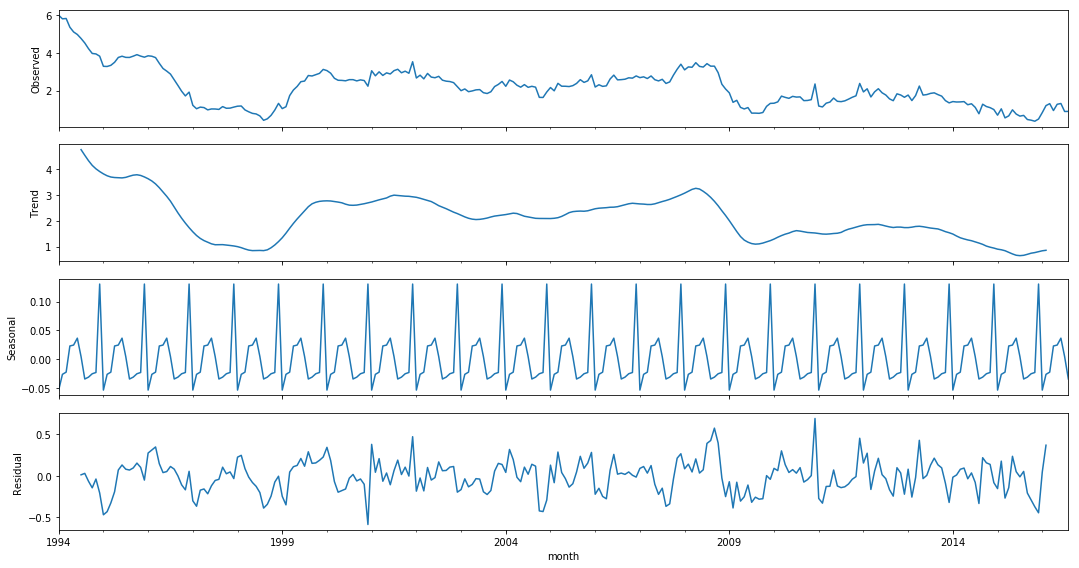

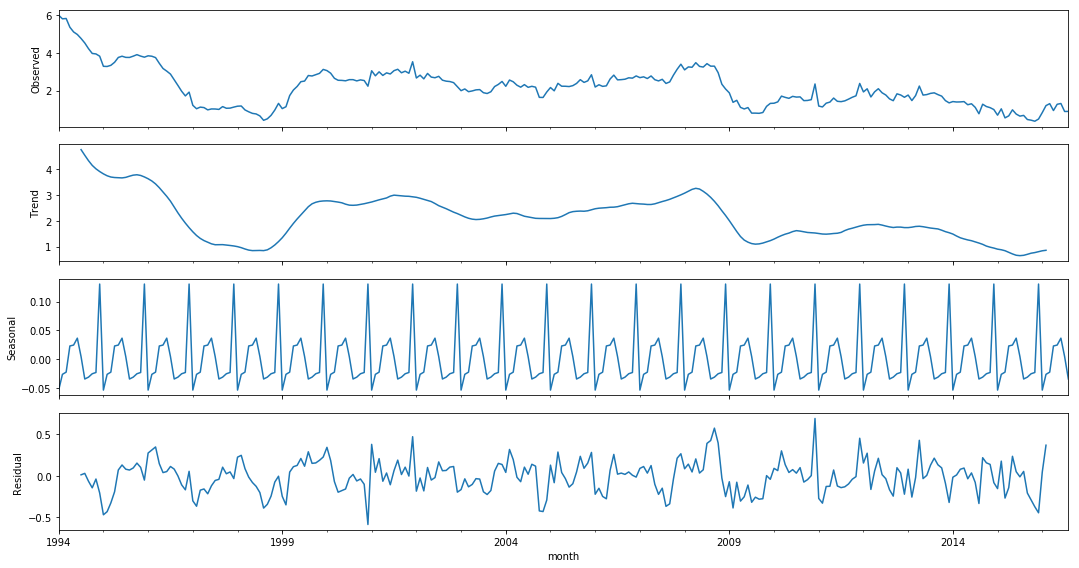

In [102]:
#посмотрим на STL-декомпозицию ряда
sm.tsa.seasonal_decompose(data['sales_box_diff'][12:]).plot()

Теперь наш ряд очень похож на стационарный.     
И критерий Дики-Фуллера отвергает гипотезу о нестационарности(т.е. ряд СТАЦИОНАРНЫЙ)   
Но **все равно осталось что-то похожее на тренд**      
Поэтому на всякий случай еще раз продифференцируем(но теперь уже обычное дифференцирование делаем):          

Критерий Дики-Фуллера p=0.000001


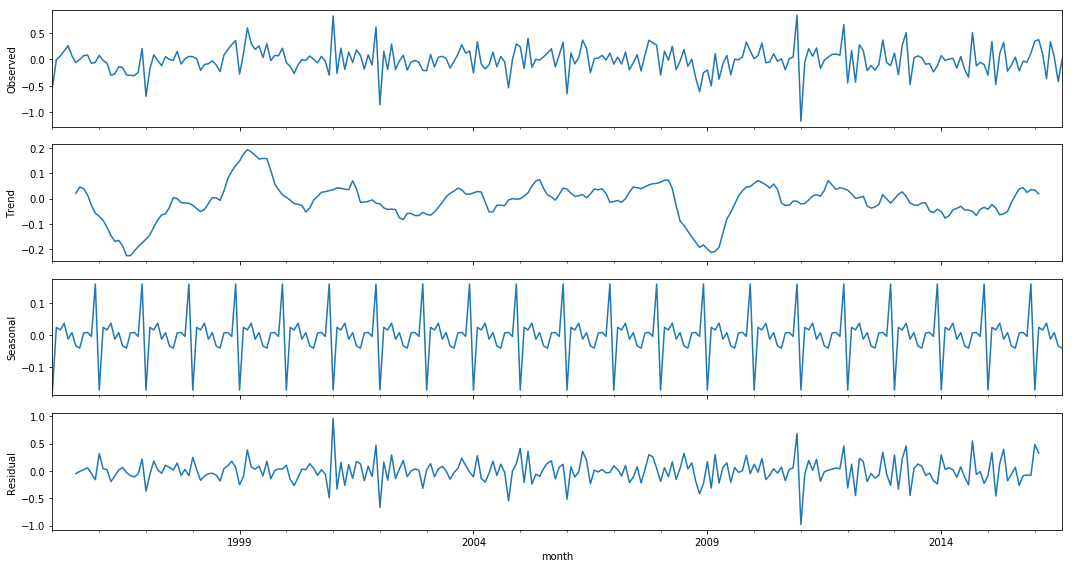

In [113]:
data['sales_box_double_diff']= data['sales_box_diff'] - data['sales_box_diff'].shift(1)
sm.tsa.seasonal_decompose(data['sales_box_double_diff'][24:]).plot()
print('Критерий Дики-Фуллера p=%f' %sm.tsa.stattools.adfuller(data['sales_box_double_diff'][24:])[1])
#Теперь все супер-пупер и визуально, и по критерию Дики-Фуллера

## 4. Выбор начальных приближений для p, q, P, Qp,q,P,Q

Посмотрим на автокорреляционную и частично автокорреляционную функцию вот этого два раза продифференцированного ряда:

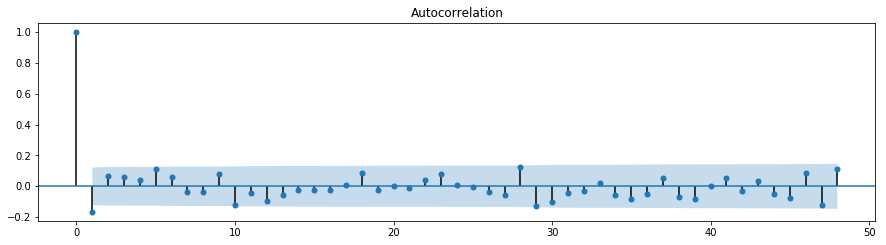

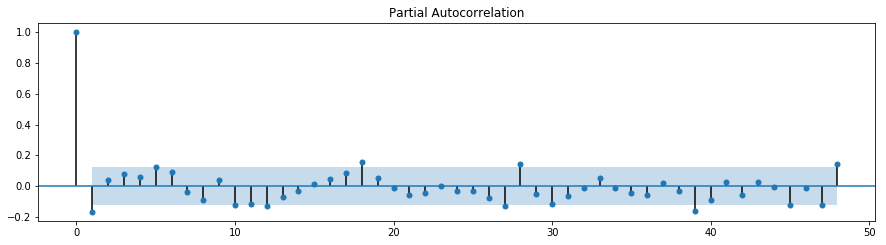

In [114]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['sales_box_double_diff'][24:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['sales_box_double_diff'][24:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [ ]:
Q=0,1
q=0, 1
P=0,1,2
p=0,1

1) По верхнему автокорреляционному графику подберем начальные приближения для q и Q:
- Максимальный сезонный лаг, значимо отличающийся от нуля, то есть вылезающий из вот этого синего коридора, это лаг 0.
  Таким образом, начальным приближением для Q** мы будем брать **0**.

- q — здесь значимо отличаются от нуля первые два несезонных лага. Таким образом, для q начальное приближение мы будем брать равным двойке.

2) По нижнему частичному автокорреляционному графику подбираем нач.приближения для P и p:
- На частично автокорреляционной функции видим три сезонных лага, значимо отличающийся от нуля — это лаги 0,12 и 48.
  Значит P мы возьмём равным трем

-  p — в начале при маленьких лагах на частично автокорреляционной функции есть несколько значимо отличающихся от нуля.
   Возьмём, допустим, p равным двум.

In [162]:
Qs = range(0, 1)
qs = range(0, 2)

Ps = range(0, 3)  
ps = range(0, 2)


D=1
d=1

In [163]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Кол-во вариантов параметров =', len(parameters_list))

Кол-во вариантов параметров = 12


Ну теперь будем обучать модель на всех этих параметрах

In [174]:
#%%time закоментим коварный декоратор
results = [] 
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
#try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['box'], order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
                                                      
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

In [175]:
results

[[(0, 0, 0, 0), 5.241225038406736],
 [(0, 0, 1, 0), 4.268897966585509],
 [(0, 0, 2, 0), 5.978351621964489],
 [(0, 1, 0, 0), 3.3698319040001152],
 [(0, 1, 1, 0), 1.170768345598649],
 [(0, 1, 2, 0), 2.5096496312094914],
 [(1, 0, 0, 0), 2.6257091572950557],
 [(1, 0, 1, 0), 0.34052090082342445],
 [(1, 0, 2, 0), 1.622923777556089],
 [(1, 1, 0, 0), 4.003439712734799],
 [(1, 1, 1, 0), 2.0219112499487117],
 [(1, 1, 2, 0), 3.3387596134639743]]

## 5. Выбор лучшей модели

In [167]:
# пять лучших моделей:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
7   (1, 0, 1, 0)  0.340521
4   (0, 1, 1, 0)  1.170768
8   (1, 0, 2, 0)  1.622924
10  (1, 1, 1, 0)  2.021911
5   (0, 1, 2, 0)  2.509650


In [148]:
#параметры лучшей модели:
print('Лучшие результаты:', best_model.summary())

Лучшие результаты:                                  Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 18 Dec 2019   AIC                              0.341
Time:                                    19:37:43   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0

## 6. Анализ остатков

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


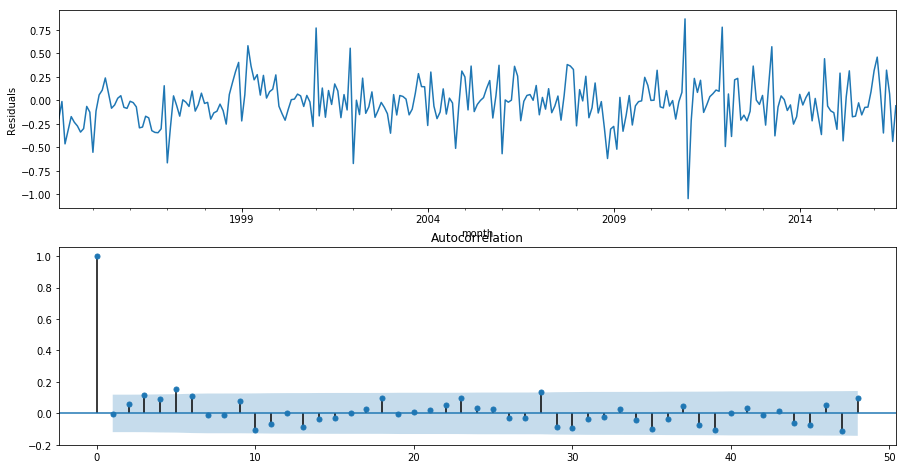

In [154]:
#строим графики:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

На графике видно, что остатки:
- несмещены(по критерию Стьюдента)
- стационарны(по критерию Дики-Фуллера)
- неавтокоррелированы

## 7. Прогноз

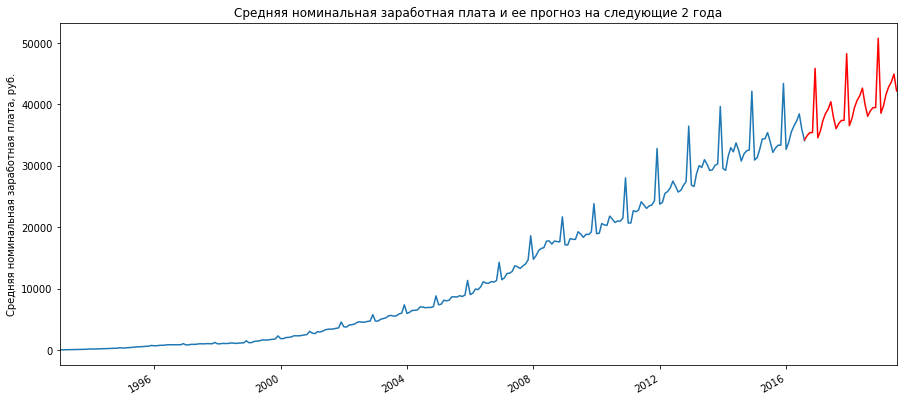

In [160]:
df2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.title(u'Средняя номинальная заработная плата и ее прогноз на следующие 2 года')
pylab.show()

Ну вот, это и есть результат прогнозирования.
Прогноз выглядит достаточно адекватным.